In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append('..')

In [2]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

import utils.nn as tu

from tqdm.auto import trange

T.__version__

'1.3.1'

In [3]:
def imshow(img, size=8):
    import math
    
    if type(img) is not np.ndarray:
        img = img.detach().cpu().numpy()

    num_dims = len(img.shape)

    if num_dims == 4:
        bs = img.shape[0]
        channels = img.shape[1]

        rows = math.ceil(math.sqrt(bs))
        cols = math.ceil(bs / rows)
        new_bs = rows * cols
        H, W = img.shape[2], img.shape[3]

        img = np.pad(img, ((0, new_bs - bs), (0, 0), (0, 0), (0, 0)))
        img = img.reshape(rows, cols, channels, H, W)
        img = np.concatenate(np.split(img, rows, axis=0), axis=3)
        img = np.concatenate(np.split(img, cols, axis=1), axis=4)
        img = img[0, 0]

    img = np.transpose(img, (1, 2, 0))
    if img.shape[-1] == 1:
        img = img[:, :, 0]
    
    fig, ax = plt.subplots(figsize=(size, size))
    ax.imshow(img)
    plt.tight_layout()

In [4]:
# img = np.random.rand(11, 3, 16, 16)
# imshow(img)

torch.Size([16, 3, 28, 28])

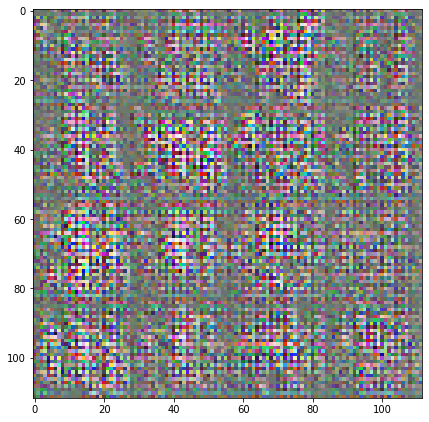

In [5]:
class MsgEncoder(nn.Module):
    def __init__(self, msg_size, img_channels):
        super().__init__()

        self.net = nn.Sequential(
            tu.reshape(-1, msg_size, 1, 1),
            tu.deconv_block(msg_size, 128 , ks=5, s=2, p=1),
            nn.Dropout(0.2),
            tu.deconv_block(128, 64, ks=5, s=1, p=2),
            nn.Dropout(0.5),
            tu.deconv_block(64, 32, ks=5, s=1, p=2),
            tu.deconv_block(32, 16, ks=5, s=2, p=1),
            nn.Dropout(0.3),
            tu.deconv_block(16, 8, ks=5, s=1, p=2),
            tu.deconv_block(8, 8, ks=5, s=1, p=2),
            nn.Dropout(0.01),
            tu.deconv_block(8, 4, ks=5, s=2, p=2),
            tu.deconv_block(4, img_channels, ks=4, s=2, p=0, a=nn.Sigmoid()),
        )

    def forward(self, z):
        return self.net(z)
    

msg_size = 15
bs = 16

encoder = MsgEncoder(msg_size, img_channels=3)
msg = T.randn(bs, msg_size)
img = encoder(msg)

imshow(img, size=6)
img.shape

In [373]:
class MsgDecoder(nn.Module):
    def __init__(self, in_channels, msg_size):
        super().__init__()
        
        self.conv = tu.conv_to_flat(
            [in_channels, 128, 128, 64, 32],
            2,
            ks=3,
            s=2,
        )

        self.dense = nn.Sequential(
            nn.LeakyReLU(0.5),
            nn.Linear(2, 128),
            nn.LeakyReLU(0.5),
            nn.Linear(128, msg_size),
        )
        self.net = nn.Sequential(
            self.conv,
            self.dense,
        )
        
    def decode(self, x):
        return self.conv(x)
        
    def forward(self, x):
        return self.net(x)
    
bs = 16
in_channels = 3
msg_size = 32

decoder = MsgDecoder(in_channels, msg_size)
img = T.rand(bs, in_channels, 32, 32)
msg = decoder(img)
msg.shape

torch.Size([16, 32])

In [374]:
class ReverseAE(tu.BaseModule):
    def __init__(self, msg_size, img_channels):
        super().__init__()
        self.msg_size = msg_size
        self.encoder = MsgEncoder(msg_size, img_channels)
        self.decoder = MsgDecoder(img_channels, msg_size)

        # This is done so that te decoder parameters are initialized
        imgs = self.encoder(self.sample(bs=1))
        self.decoder(imgs)

    @property
    def device(self):
        return next(self.encoder.parameters()).device

    def sample(self, bs):
        return T.rand(bs, self.msg_size).to(self.device)

    def forward(self, bs):
        msg = self.sample(bs)
        img = self.encoder(msg)
        return img

    def configure_optim(self, lr, bs, noise_size):
        self.noise_size = noise_size
        self.bs = bs
        self.optim = T.optim.Adam(self.parameters(), lr)

    def optim_step(self, *_):
        def apply_noise(t):
            noise = T.randn(t.shape) / self.noise_size
            noise = noise.to(self.device)
            return t * noise

        msg = self.sample(self.bs)
        img = self.encoder(msg)
        img = apply_noise(img)
        pred_msg = self.decoder(img)
        
        loss = F.mse_loss(pred_msg, msg)

        if loss.requires_grad:
            self.optim.zero_grad()
            loss.backward()
            self.optim.step()

        return loss.item(), {
            'pred_msg': pred_msg,
            'msg': msg,
            'img': img
        }

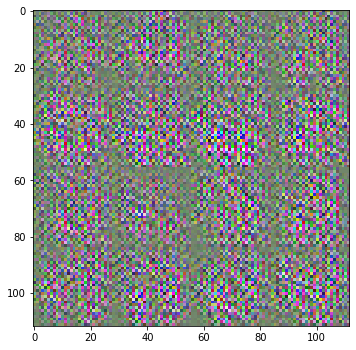

In [375]:
bs = 16
msg_size = 32
model = ReverseAE(msg_size, img_channels=3)

for _ in range(5):
    model.configure_optim(lr=0.001, bs=128, noise_size=0.5)
    loss, info = model.optim_step()

img = model(16)
imshow(img, size=5)

In [376]:
print(model.summary())

 > Custom Module                          | 0,626,615
 >               encoder: MsgEncoder      |   377,781
 >               decoder: MsgDecoder      |   248,834



In [377]:
msg_size = 32
model = ReverseAE(msg_size, img_channels=1)
model = model.to('cuda')

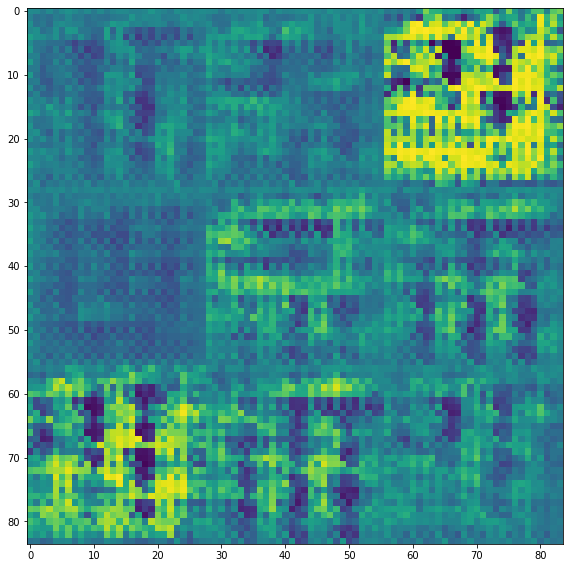

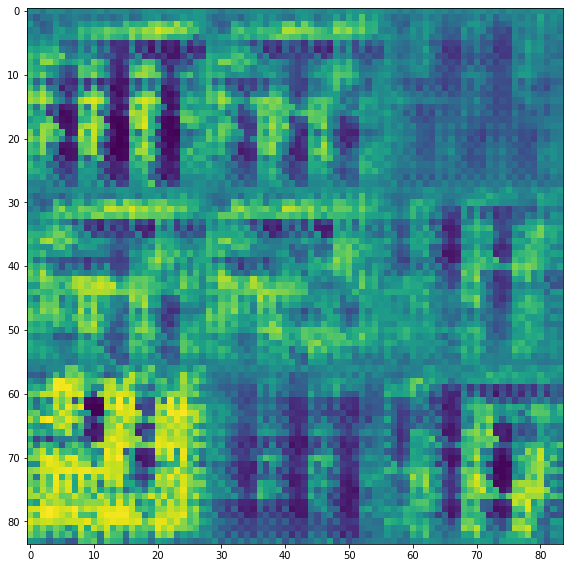

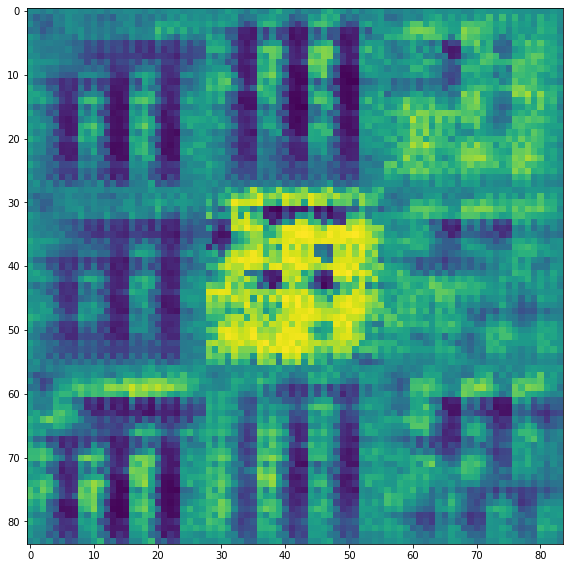

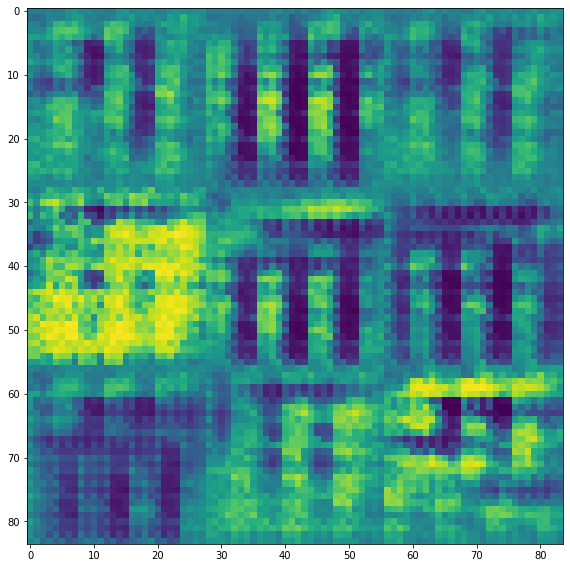

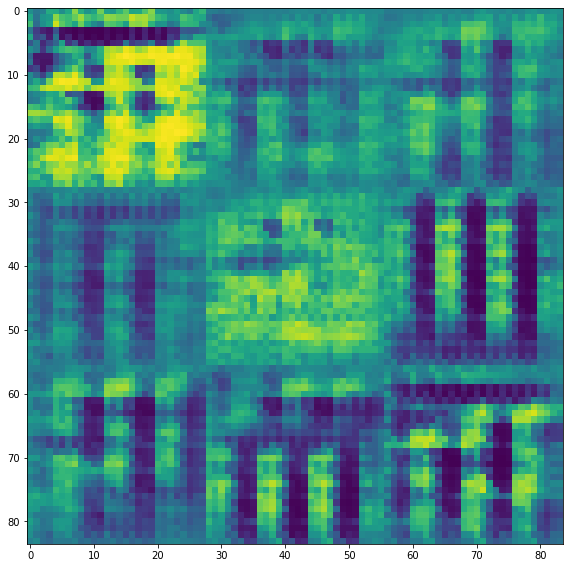

In [378]:
its = 1024
epochs = 5

for e in range(epochs):
    tr = trange(its)
    for _ in tr:
        model.configure_optim(lr=0.0001, bs=256, noise_size=1 / (epochs - e))
        loss, info = model.optim_step()
        tr.set_description(f'Loss: {loss:0.6f}')

    img = model(9)
    imshow(img, size=8)
    plt.show()

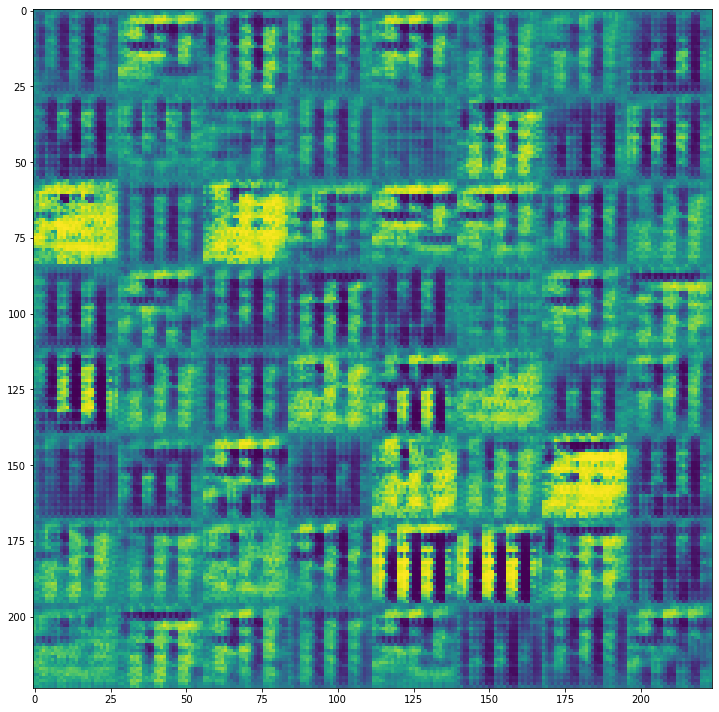

In [379]:
img = model(64)
imshow(img, size=10)

In [380]:
import torchvision
from torchvision import transforms

In [381]:
dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ]),
    download=True
)

mk_data_loader = lambda bs: T.utils.data.DataLoader(
    dataset=dataset,
    batch_size=bs,
#     shuffle=True
)

dl = mk_data_loader(1024)
X, y = next(iter(dl))
X.shape

torch.Size([1024, 1, 28, 28])

torch.Size([256, 1, 28, 28])

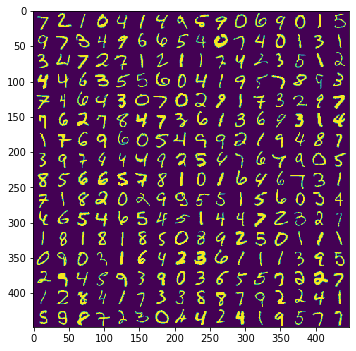

In [382]:
bs = 20

# imgs = T.rand(10, 1, 28, 28)

# for i in range(10):
#     imgs[i] = X[y == i][0]
imgs = X[:256]
labels = y[:256]
    
img = imgs.to('cuda')
imshow(img, size=5)
img.shape

In [383]:
msg = model.decoder(img)
pred_img = model.encoder(msg)
msg.shape, pred_img.shape

(torch.Size([256, 32]), torch.Size([256, 1, 28, 28]))

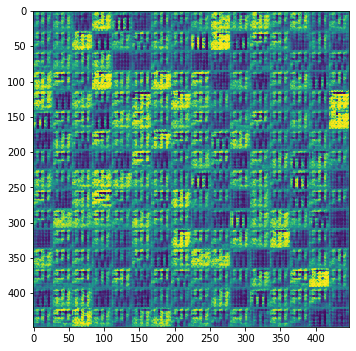

In [384]:
imshow(pred_img, size=5)

In [385]:
msg = model.decoder.decode(img).detach().cpu().numpy()
img = img.detach().cpu().numpy()
img.shape, msg.shape

((256, 1, 28, 28), (256, 2))

In [386]:
import matplotlib as mpl

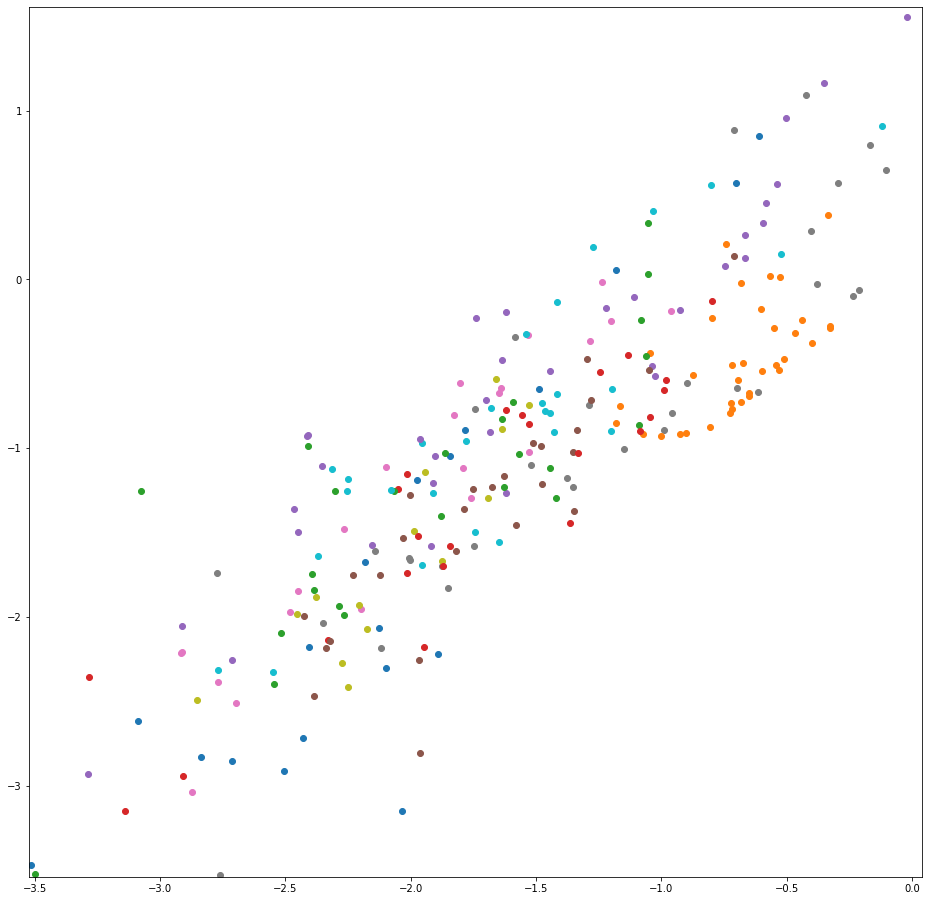

In [387]:
def plot_emb(img, msg, labels):
    fig, ax = plt.subplots(figsize=(16, 16))

    pad = 0.01
    s = 0.05
    ax.set_xlim(msg[:,1].min() - pad, msg[:,1].max() + s + pad)
    ax.set_ylim(msg[:,0].min() - pad, msg[:,0].max() + s + pad)

    for idx in range(len(img)):
        i = img[idx, 0]
        y, x = msg[idx][0], msg[idx][1]
        i = mpl.cm.viridis(i)
        i[:,:,3] = 0.5
        
        c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
        c = c[labels[idx]]
        ax.scatter(x, y, c=c)
#         ax.imshow(i, extent=(x, x + s, y, y + s))
    plt.show()
    
    
plot_emb(img, msg, labels)